**The National Longitudinal Study of Adolescent Health (AddHealth)** is a representative school-based survey of adolescents in grades 7-12 in the United States. The Wave 1 survey focuses on factors that may influence adolescents’ health and risk behaviors, including personal traits, families, friendships, romantic relationships, peer groups, schools, neighborhoods, and communities

**Population**: adolescents in grades 7-12 in the US as recorded in AddHealth data

**Question**: Does the frequency of exercise relate to the trouble of falling asleep between regular vs non-regular smokers? (regular: smoke regularly for at least 1 cigarette every day for 30 days)


**Variables**
1. Explanatory variable: The frequency of exercise in the past week (column used: H1DA6). The categorical value is explained below. We will filter out value 6 (refused) and 8 (don't know).

| Value      | Description |
| -----------| -----------|
| 0      | no exercise     |
| 1   | 1 or 2 times       |
| 2   | 3 or 4 times       |
| 3   | 5 or more times    |
| 6   | refused          |
| 8   | don’t know        |

2. Response variable: trouble falling asleep (column used: H1GH18).

    The value in the column H1GH18 is 0 for "never" and 1-4 for "at least once". Therefore for this column, the values 1-4 will be converted to 1 to denote "at least once" for having trouble falling asleep. We also filter out value 6 (refused) and 8 (don't know) for this column.
    
3. Moderating variable: whether a person is a regular smoker (column used: H1TO3). We only use column of value 0 (no) or 1 (yes).

In [1]:
# Import modules
import pandas as pd
import scipy.stats
import seaborn
import matplotlib.pyplot as plt
import itertools
import statsmodels.stats.multitest as mt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read and subset the columns of innterest H1TO15 
df = pd.read_csv("../addhealth.csv", low_memory=False)[["H1DA6", "H1GH18", "H1TO3"]] \
    .rename(columns={"H1DA6": "exercise_freq", "H1GH18": "trouble_sleep", "H1TO3": "regular_smoker"}) \
    .apply(pd.to_numeric, errors='coerce')
df

,exercise_freq,trouble_sleep,regular_smoker
0,3,0,0
1,0,0,1
2,0,1,0
3,2,0,1
4,0,1,0
...,...,...,...
6499,3,1,7
6500,0,1,7
6501,2,1,1
6502,0,1,0


In [3]:
# subset the rows: we only take values below 5 since 6 is "refused" and 8 is "don't know"
df = df.loc[lambda r: (r["exercise_freq"] < 5) & (r["trouble_sleep"] < 5) & (r["regular_smoker"] <= 1)] \
    .dropna() \
    .astype(int)

# The values 1-4 are converted to 1 to denote "at least once" for having trouble falling asleep
df.loc[df["trouble_sleep"] >= 1, "trouble_sleep"] = 1
df

,exercise_freq,trouble_sleep,regular_smoker
0,3,0,0
1,0,0,1
2,0,1,0
3,2,0,1
4,0,1,0
...,...,...,...
6497,3,1,0
6498,0,0,0
6501,2,1,1
6502,0,1,0


## Chi-square analyses taking into account moderation

===== Chi-square analysis for Non-regular smoker =====

----- Contingency table -----
exercise_freq    0    1    2    3
trouble_sleep                    
0               98  159  140  158
1              130  309  248  235

----- Column percentages -----
exercise_freq         0         1         2         3
trouble_sleep                                        
0              0.429825  0.339744  0.360825  0.402036
1              0.570175  0.660256  0.639175  0.597964

----- Chi-square analysis -----
   chi-square value   p-value  expected count
0          6.954999  0.073346               3

----- Perform multiple (post-hoc) testing -----
   group_a  group_b     p-val     p-adj  reject
0        0        1  0.025915  0.155491   False
4        1        3  0.069258  0.415549   False
1        0        2  0.106852  0.641113   False
2        0        3  0.552799  1.000000   False
3        1        2  0.567306  1.000000   False
5        2        3  0.266248  1.000000   False


===== Chi-square a

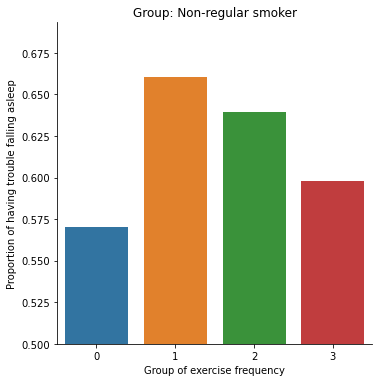

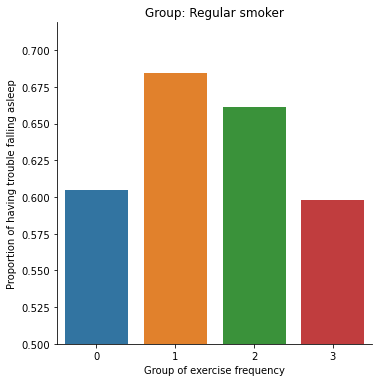

In [4]:
for i in [0,1]:
    sub = df[df["regular_smoker"] == i]
    group = "Non-regular smoker" if i ==0 else "Regular smoker"
    print("===== Chi-square analysis for %s =====\n" % group)

    # contingency table of observed counts
    ct = pd.crosstab(sub["trouble_sleep"], sub['exercise_freq'])
    print("----- Contingency table -----")
    print(ct)
    print("\n----- Column percentages -----")
    print(ct/ct.sum(axis=0))
    
    # Using histogram to plot the frequency shown above
    seaborn.factorplot(x="exercise_freq", y="trouble_sleep", data=sub, kind="bar", ci=None)
    plt.ylim(bottom = 0.5)
    plt.xlabel("Group of exercise frequency")
    plt.ylabel("Proportion of having trouble falling asleep")
    plt.title("Group: %s" % group)
    
    # Chi-square analysis
    print("\n----- Chi-square analysis -----")
    chival, pval, expcount, expfreq = scipy.stats.chi2_contingency(ct)
    # chi-square value, p value, expected counts
    chidf = pd.DataFrame({"chi-square value": [chival], "p-value": [pval], "expected count": [expcount]})
    print(chidf)
    
    print("\n----- Perform multiple (post-hoc) testing -----")
    all_pairs = list(itertools.combinations(ct.columns, 2))
    rows = []
    for pair in all_pairs:
        ct_sub = ct[[pair[0],pair[1]]]
        # Index 1 is the p-value
        cur_pval = scipy.stats.chi2_contingency(ct_sub, correction=True)[1]
        rows.append({"group_a":pair[0], "group_b":pair[1], "p-val":cur_pval})
    pair_df = pd.DataFrame(rows)
    reject, padj = mt.multipletests(pair_df["p-val"], method='bonferroni')[:2]
    pair_df["p-adj"], pair_df["reject"] = padj,reject
    print(pair_df.sort_values("p-adj"))
    
    print("\n================================================================================\n")

### Conclusion

From the chi-square analyses above, we see the relationship between exercise frequency and trouble of falling asleep.
The general observation is that, the group who doesn't exercise (surprisingly) has less trouble falling asleep. But the more a person exercise, the less likely for the person to have trouble falling asleep.

However, the effect is different between regular vs non-regular smokers as shown from the chi-square analysis:
1. Non-regular smoker: 
    - chi-square_value: 6.95
    - p-value: 0.07
2. Regular smoker:
    - chi-square_value: 7.97
    - p-value: 0.047
    
The analysis shows significant relation between exercise frequency and trouble of falling asleep in regular smoker ($p < 0.05$) but not in non-regular smoker ($p > 0.05$). 